# Traffic volume prediction on LA's 101 North freeway

### Univariate time series prediction with getML

In this tutorial, we demonstrate a time series application of getML. 

We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/) and [tsfresh](https://tsfresh.readthedocs.io/en/latest/). 

getML's relational learning algorithms outperform Prophet's classical time series approach by **~14%** and tsfresh's brute force approaches to feature engineering by **~26%** (measured in terms of the **predictive R-squared**).

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __traffic volume__ 
- Source data: __Univariate time series__
- Population size: __47497__

_Author: Patrick Urbanke_

# Background

The data set features some particularly interesting characteristics common for time series, which classical models may struggle to deal with. Such characteristics are:

- High frequency (every five minutes)
- Dependence on irregular events (holidays, Dodgers games)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


To quote the maintainers of the data set:

"_This loop sensor data was collected for the Glendale on ramp for the 101 North freeway in Los Angeles. It is close enough to the stadium to see unusual traffic after a Dodgers game, but not so close and heavily used by game traffic so that the signal for the extra traffic is overly obvious._"

The dataset was originally collected for this paper:

> "Adaptive event detection with time-varying Poisson processes" A. Ihler, J. Hutchins, and P. Smyth
Proceedings of the 12th ACM SIGKDD Conference (KDD-06), August 2006. 

It is maintained by the UCI Machine Learning Repository:

> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
from datetime import datetime
import gc
import os
from urllib import request
import time

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import scipy

from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

For various technical reasons, we want to keep our MyBinder notebook short. That is why we pre-store the features for prophet and tsfresh. However, you are very welcome to try this at home and fully reproduce our results. You can just set the two constants to "True".

In [2]:
RUN_PROPHET = False
RUN_TSFRESH = False

if RUN_PROPHET:
    from fbprophet import Prophet

if RUN_TSFRESH:
    import tsfresh
    from tsfresh.utilities.dataframe_functions import roll_time_series
    from tsfresh.feature_selection.relevance import calculate_relevance_table

In [3]:
import getml

getml.engine.set_project('dodgers')


Connected to project 'dodgers'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the UC Irvine Machine Learning repository:

In [4]:
fname = "Dodgers.data"

if not os.path.exists(fname):
    fname, res = request.urlretrieve(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/event-detection/" + fname, 
        fname
    )
    
data_full_pandas = pd.read_csv(fname, header=None)

If we use the pre-stored features, we have to download them as well:

In [5]:
PROPHET_FILES = [
    "predictions_prophet_train.csv",
    "predictions_prophet_test.csv",
    "combined_train_pandas.csv",
    "combined_test_pandas.csv"
]

if not RUN_PROPHET:
    for fname in PROPHET_FILES:
        if not os.path.exists(fname):
            fname, res = request.urlretrieve(
                "https://static.getml.com/datasets/dodgers/" + fname, 
                fname
            )

In [6]:
TSFRESH_FILES = [
    "tsfresh_train_pandas.csv",
    "tsfresh_test_pandas.csv"
]

if not RUN_TSFRESH:
    for fname in TSFRESH_FILES:
        if not os.path.exists(fname):
            fname, res = request.urlretrieve(
                "https://static.getml.com/datasets/dodgers/" + fname, 
                fname
            )

Prophet is pretty strict about how the columns should be named, so we adapt to these restriction:

In [7]:
data_full_pandas.columns = ["ds", "y"]

data_full_pandas = data_full_pandas[data_full_pandas["y"] >= 0]

data_full_pandas = data_full_pandas.reset_index()

del data_full_pandas["index"]

data_full_pandas["ds"] = [
    datetime.strptime(dt, "%m/%d/%Y %H:%M") for dt in data_full_pandas["ds"]
]

In [8]:
data_full_pandas

,ds,y
0,2005-04-11 07:35:00,23
1,2005-04-11 07:40:00,42
2,2005-04-11 07:45:00,37
3,2005-04-11 07:50:00,24
4,2005-04-11 07:55:00,39
...,...,...
47492,2005-09-30 23:45:00,14
47493,2005-09-30 23:50:00,12
47494,2005-09-30 23:55:00,8
47495,2005-10-01 00:00:00,13


We also want to separate our data set into a training and testing set:

In [9]:
separation = datetime.strptime("8/20/2005 0:00", "%m/%d/%Y %H:%M")

data_train_pandas = data_full_pandas[data_full_pandas["ds"] < separation]
data_test_pandas = data_full_pandas[data_full_pandas["ds"] > separation]

__Data visualization__

The original traffic time series is plotted below. As you can see, the data set is rather noisy. This is because it is measured in 5-minute intervals.

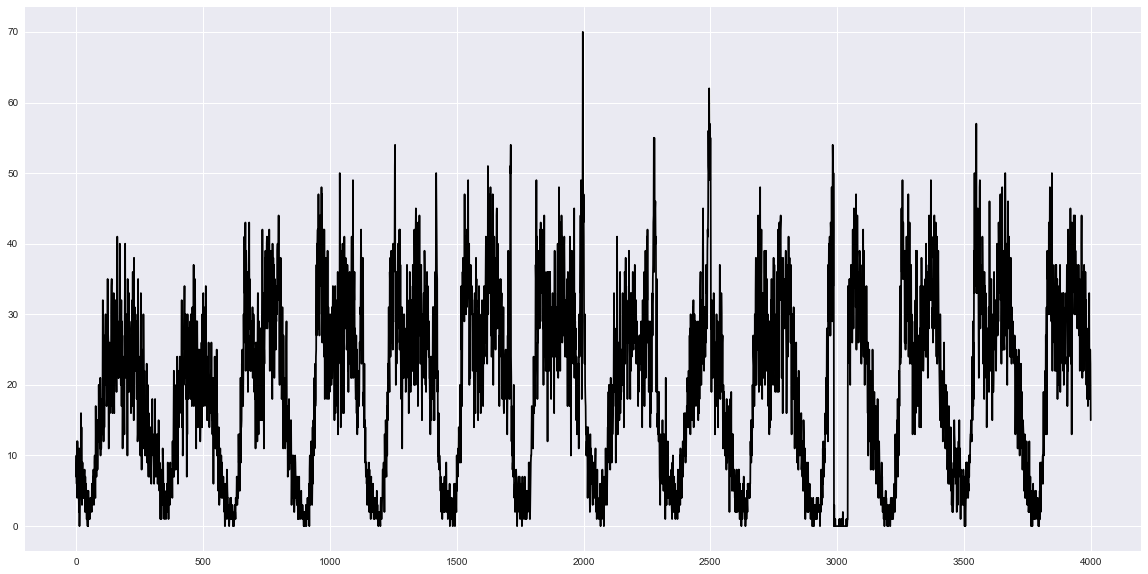

In [10]:
col_data = 'black'
col_getml = 'darkviolet'
col_getml_alt = 'coral'
col_prophet = 'cornflowerblue'

plt.subplots(figsize=(20, 10))

length = 4000

plt.plot(np.asarray(data_test_pandas["y"])[:length], color=col_data)

### 1.2 Prepare data for getML

In [11]:
data_full = getml.data.DataFrame.from_pandas(data_full_pandas, "data_full")
data_train = getml.data.DataFrame.from_pandas(data_train_pandas, "data_train")
data_test = getml.data.DataFrame.from_pandas(data_test_pandas, "data_test")

In [12]:
for df in [data_full, data_train, data_test]:
    df.set_role("y", getml.data.roles.target)
    df.set_role("ds", getml.data.roles.time_stamp)

In [13]:
data_full

Name,ds,y
Role,time_stamp,target
Units,"time stamp, comparison only",
0,2005-04-11 07:35:00,23
1,2005-04-11 07:40:00,42
2,2005-04-11 07:45:00,37
3,2005-04-11 07:50:00,24
4,2005-04-11 07:55:00,39
,...,...
47492,2005-09-30 23:45:00,14
47493,2005-09-30 23:50:00,12


__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables.

### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). This is done abstractly using [Placeholders](https://docs.getml.com/latest/user_guide/data_model/data_model.html#placeholders)

The data model consists of two tables:
* __Population table__ `traffic_{test/train}`: holds target and the contemporarily available time-based components
* __Peripheral table__ `traffic`: same table as the population table
* Join between both placeholders specifies (`horizon`) to prevent leaks and (`memory`) that keeps the computations feasible

In [14]:
population = getml.data.Placeholder('population')

peripheral = getml.data.Placeholder('peripheral')

# 1. The horizon is 1 hour (we predict the traffic volume in one hour). 
# 2. The memory is 2 hours, so we allow the algorithm to 
#    use information from up to 2 hours ago. 
# 3. We allow lagged targets. Thus, the algorithm can 
#    identify autoregressive processes.

population.join(
    peripheral,
    time_stamp='ds',
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.hours(2),
    allow_lagged_targets=True
)

population

placeholder   other placeholder   allow lagged targets   horizon   join keys used   memory   other join keys used   other time stamps used   relationship   time stamps used   upper time stamps used
  0   population    peripheral          True                   3600.0                     7200.0                          ds                       many-to-many   ds

## 2. Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [15]:
mapping = getml.preprocessors.Mapping()

seasonal = getml.preprocessors.Seasonal()

fast_prop = getml.feature_learning.FastPropModel(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,
    aggregation=getml.feature_learning.FastPropModel.agg_sets.All,
)

relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [16]:
pipe = getml.pipeline.Pipeline(
    tags=['memory: 2h', 'horizon: 1h', 'fast_prop', 'relboost'],
    population=population,
    peripheral=[peripheral],
    preprocessors=[seasonal, mapping],
    feature_learners=[fast_prop, relboost],
    predictors=[predictor]
)

### 2.2 Model training

In [17]:
pipe.check(data_train, [data_full])

Checking data model...
OK.


In [18]:
pipe.fit(data_train, [data_full])

Checking data model...
OK.

Preprocessing...
[========================================] 100%

FastProp: Trying 1966 features...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:14m:23.052742



Pipeline(preprocessors=['Seasonal', 'Mapping'],
         feature_learners=['FastPropModel', 'RelboostModel'],
         feature_selectors=[],
         include_categorical=False,
         peripheral=['peripheral'],
         population='population',
         predictors=['XGBoostRegressor'],
         tags=['memory: 2h', 'horizon: 1h', 'fast_prop', 'relboost'],
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/dodgers/sdjwqL/0/

### 2.3 Model evaluation

In [19]:
pipe.score(
        population_table=data_test,
        peripheral_tables=[data_full]
)


Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-05-20 12:13:59,data_train,y,4.4691,6.1547,0.7807
1,2021-05-20 12:14:55,data_test,y,4.6409,6.3889,0.7623


In [20]:
predictions_getml_test = pipe.predict(
    population_table=data_test,
    peripheral_tables=[data_full]
)


Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



### 2.4 Benchmark against Prophet

Prophet is a library for generating predictions on univariate time series that contain strong seasonal components. We would therefore expect it to do well on this particular time series.

In [21]:
if RUN_PROPHET:
    model_prophet = Prophet()

    model_prophet = model_prophet.fit(data_train_pandas)

    predictions_prophet_train = model_prophet.predict(data_train_pandas)["yhat"]
    predictions_prophet_test = model_prophet.predict(data_test_pandas)["yhat"]
else:
    predictions_prophet_train = pd.read_csv("predictions_prophet_train.csv")["yhat"]
    predictions_prophet_test = pd.read_csv("predictions_prophet_test.csv")["yhat"]

Since we are not using the getML engine for Prophet, we have to implement the metrics ourselves. Luckily, that is not very hard.

In [22]:
in_sample = dict()
out_of_sample = dict()

In [23]:
def r_squared(yhat, y):
    yhat = np.asarray(yhat)
    y = np.asarray(y)
    r = scipy.stats.pearsonr(yhat, y)[0]
    return r * r
    
in_sample["rsquared"] = r_squared(predictions_prophet_train, data_train_pandas["y"])
out_of_sample["rsquared"] = r_squared(predictions_prophet_test, data_test_pandas["y"])

In [24]:
def rmse(yhat, y):
    yhat = np.asarray(yhat)
    y = np.asarray(y)
    return np.sqrt(
        ((y - yhat)*(y - yhat)).sum()/len(y)
    )

in_sample["rmse"] = rmse(predictions_prophet_train, data_train_pandas["y"])
out_of_sample["rmse"] = rmse(predictions_prophet_test, data_test_pandas["y"])

In [25]:
def mae(yhat, y):
    yhat = np.asarray(yhat)
    y = np.asarray(y)
    return np.abs(y - yhat).sum()/len(y)
    
in_sample["mae"] = mae(predictions_prophet_train, data_train_pandas["y"])
out_of_sample["mae"] = mae(predictions_prophet_test, data_test_pandas["y"])

In [26]:
print("""
In sample mae: {:.4f}
In sample rmse: {:.4f}
In sample rsquared: {:.4f}\n
Out of sample mae: {:.4f}
Out of sample rmse: {:.4f}
Out of sample rsquared: {:.4f}
""".format(
    in_sample['mae'], 
    in_sample['rmse'],
    in_sample['rsquared'],
    out_of_sample['mae'], 
    out_of_sample['rmse'],
    out_of_sample['rsquared'])
)


In sample mae: 5.6729
In sample rmse: 7.5989
In sample rsquared: 0.6655

Out of sample mae: 6.2245
Out of sample rmse: 8.3225
Out of sample rsquared: 0.6306



Let's take a closer look at the predictions to get a better understanding why getML does better than Prophet.

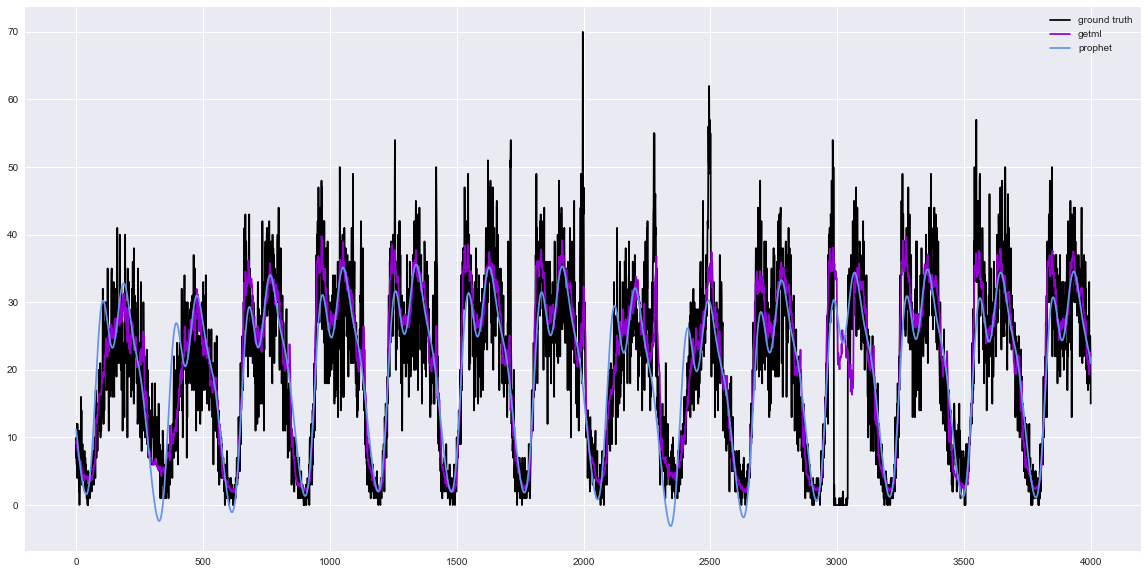

In [27]:
length = 4000

plt.subplots(figsize=(20, 10))

plt.plot(np.asarray(data_test_pandas["y"])[:length], color=col_data, label="ground truth")
plt.plot(predictions_getml_test[:length], color=col_getml, label="getml")
plt.plot(predictions_prophet_test[:length], color=col_prophet, label="prophet")
plt.legend(loc="upper right")

As this plot indicates, getML does better than Prophet, because it can integrate autoregressive processes in addition to seasonal data.

### 2.5 Benchmark against tsfresh

tsfresh is a library for generating features on time series. It uses a brute-force approach: It generates a large number of hard-coded features and then does a feature selection.

For convenience, we have built a wrapper around tsfresh.

As we have discussed in a [different notebook](https://nbviewer.jupyter.org/github/getml/getml-demo/blob/master/air_pollution_demo.ipynb), tsfresh consumes a lot of memory. To limit the memory consumption to a feasible level, we only use tsfresh's MinimalFCParameters and IndexBasedFCParameters, which are a superset of the TimeBasedFCParameters.

In [28]:
class TSFreshBuilder():
    
    def __init__(self, num_features, memory, column_id, time_stamp, target):
        """
        Scikit-learn style feature builder based on TSFresh.
        
        Args:
            
            num_features: The (maximum) number of features to build.
            
            memory: How much back in time you want to go until the
                    feature builder starts "forgetting" data.
                    
            column_id: The name of the column containing the ids.
            
            time_stamp: The name of the column containing the time stamps.
            
            target: The name of the target column.
        """
        self.num_features = num_features
        self.memory = memory
        self.column_id = column_id
        self.time_stamp = time_stamp
        self.target = target
        
        self.selected_features = []
        
    def _add_original_columns(self, original_df, df_selected):
        for colname in original_df.columns:
            df_selected[colname] = np.asarray(
                original_df[colname])
                    
        return df_selected

    def _extract_features(self, df):
        df_rolled = roll_time_series(
            df, 
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            max_timeshift=self.memory
        )
        
        extracted_minimal = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
        )
        
        extracted_index_based = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.settings.IndexBasedFCParameters()
        )
        
        extracted_features = pd.concat(
            [extracted_minimal, extracted_index_based], axis=1
        )
        del extracted_minimal
        del extracted_index_based
        
        gc.collect()
        
        extracted_features[
            extracted_features != extracted_features] = 0.0  
        
        extracted_features[
            np.isinf(extracted_features)] = 0.0 
        
        return extracted_features
        
    def _print_time_taken(self, begin, end):

        seconds = end - begin

        hours = int(seconds / 3600)
        seconds -= float(hours * 3600)

        minutes = int(seconds / 60)
        seconds -= float(minutes * 60)

        seconds = round(seconds, 6)

        print(
            "Time taken: " + str(hours) + "h:" +
            str(minutes) + "m:" + str(seconds)
        )

        print("")
        
    def _remove_target_column(self, df):
        colnames = np.asarray(df.columns)
        
        if self.target not in colnames:
            return df
        
        colnames = colnames[colnames != self.target]
        
        return df[colnames]
        
    def _select_features(self, df, target):
        df_selected = tsfresh.select_features(
            df, 
            target
        )
        
        colnames = np.asarray(df_selected.columns)

        correlations = np.asarray([
            np.abs(pearsonr(target, df_selected[col]))[0] for col in colnames
        ])
        
        # [::-1] is somewhat unintuitive syntax,
        # but it reverses the entire column.
        self.selected_features = colnames[
            np.argsort(correlations)
        ][::-1][:self.num_features]

        return df_selected[self.selected_features]
        
    def fit(self, df):
        """
        Fits the features.
        """
        begin = time.time()

        target = np.asarray(df[self.target])
        
        df_without_target = self._remove_target_column(df)
        
        df_extracted = self._extract_features(
            df_without_target)
        
        df_selected = self._select_features(
            df_extracted, target)
                
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)

        end = time.time()
        
        self._print_time_taken(begin, end)
        
        return df_selected
    
    def transform(self, df):
        """
        Transforms the raw data into a set of features.
        """
        df_extracted = self._extract_features(df)
        
        df_selected = df_extracted[self.selected_features]
        
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)
                                         
        return df_selected

We need to lag our target variable, so we can input as a feature to tsfresh.

In [29]:
y_lagged = np.asarray(data_full_pandas["y"][:-12])
data_full_tsfresh = data_full_pandas[12:]
data_full_tsfresh["y_lagged"] = y_lagged

data_full_tsfresh["id"] = 1

<ipython-input-29-f49d2e591a42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full_tsfresh["y_lagged"] = y_lagged
<ipython-input-29-f49d2e591a42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full_tsfresh["id"] = 1


In [30]:
data_train_tsfresh = data_full_tsfresh[data_full_tsfresh["ds"] < separation]
data_test_tsfresh = data_full_tsfresh[data_full_tsfresh["ds"] >= separation]

In [31]:
data_train_tsfresh

,ds,y,y_lagged,id
12,2005-04-11 08:35:00,42,23,1
13,2005-04-11 08:40:00,41,42,1
14,2005-04-11 08:45:00,38,37,1
15,2005-04-11 08:50:00,38,24,1
16,2005-04-11 08:55:00,40,39,1
...,...,...,...,...
35867,2005-08-19 23:35:00,6,18,1
35868,2005-08-19 23:40:00,16,25,1
35869,2005-08-19 23:45:00,11,25,1
35870,2005-08-19 23:50:00,10,18,1


In [32]:
data_test_tsfresh

,ds,y,y_lagged,id
35872,2005-08-20 00:00:00,13,9,1
35873,2005-08-20 00:05:00,7,24,1
35874,2005-08-20 00:10:00,10,8,1
35875,2005-08-20 00:15:00,6,13,1
35876,2005-08-20 00:20:00,12,14,1
...,...,...,...,...
47492,2005-09-30 23:45:00,14,28,1
47493,2005-09-30 23:50:00,12,18,1
47494,2005-09-30 23:55:00,8,36,1
47495,2005-10-01 00:00:00,13,21,1


We build 20 features, just like we have with getML.

In [33]:
tsfresh_builder = TSFreshBuilder(
    num_features=20,
    memory=24,
    column_id="id",
    time_stamp="ds",
    target="y"
)

In [34]:
if RUN_TSFRESH:
    tsfresh_train_pandas = tsfresh_builder.fit(data_train_tsfresh)
    tsfresh_test_pandas = tsfresh_builder.transform(data_test_tsfresh)
else:
    tsfresh_train_pandas = pd.read_csv("tsfresh_train_pandas.csv")
    tsfresh_test_pandas = pd.read_csv("tsfresh_test_pandas.csv")

Because tsfresh does not come with built-in predictors, we upload the generated features into a getML pipeline.

In [35]:
tsfresh_train = getml.data.DataFrame.from_pandas(tsfresh_train_pandas, "tsfresh_train")
tsfresh_test = getml.data.DataFrame.from_pandas(tsfresh_test_pandas, "tsfresh_test")

In [36]:
for df in [tsfresh_train, tsfresh_test]:
    df.set_role("y", getml.data.roles.target)
    df.set_role("ds", getml.data.roles.time_stamp)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)
    df.set_role(["y_lagged", "id"], getml.data.roles.unused_float)

In [37]:
tsfresh_train

Name,ds,y,y_lagged__mean,y_lagged__sum_values,y_lagged__median,y_lagged__maximum,y_lagged__minimum,y_lagged__percentage_of_reoccurring_values_to_all_values,y_lagged__standard_deviation,y_lagged__skewness,y_lagged__variance,y_lagged__kurtosis,y_lagged__length,y_lagged,id
Role,time_stamp,target,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,unused_float,unused_float
Units,"time stamp, comparison only",,,,,,,,,,,,,,
0,2005-04-11 08:35:00,42,23,23,23,23,23,0,0,0,0,0,1,23,1
1,2005-04-11 08:40:00,41,32.5,65,32.5,42,23,0,9.5,0,90.25,0,2,42,1
2,2005-04-11 08:45:00,38,34,102,37,42,23,0,8.0416,-1.2435,64.6667,0,3,37,1
3,2005-04-11 08:50:00,38,31.5,126,30.5,42,23,0,8.2006,0.2261,67.25,-4.6053,4,24,1
4,2005-04-11 08:55:00,40,33,165,37,42,23,0,7.9246,-0.4313,62.8,-2.9949,5,39,1
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35855,2005-08-19 23:35:00,6,21.16,529,21,37,10,0.84,5.0333,0.7576,25.3344,3.1125,25,18,1
35856,2005-08-19 23:40:00,16,21.32,533,21,37,10,0.88,5.089,0.6509,25.8976,2.7456,25,25,1


We use an untuned XGBoostRegressor to generate predictions from our tsfresh features, just like we have for getML.

In [38]:
predictor = getml.predictors.XGBoostRegressor()

pipe_tsfresh = getml.pipeline.Pipeline(
    tags=['tsfresh'],
    predictors=[predictor]
)

In [39]:
pipe_tsfresh.fit(tsfresh_train)

Checking data model...
OK.

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:1.453882



Pipeline(preprocessors=[],
         feature_learners=[],
         feature_selectors=[],
         include_categorical=False,
         peripheral=[],
         population='POPULATION',
         predictors=['XGBoostRegressor'],
         tags=['tsfresh'],
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/dodgers/ynnAmG/0/

In [40]:
pipe_tsfresh.score(tsfresh_test)

,date time,set used,target,mae,rmse,rsquared
0,2021-05-20 12:15:52,tsfresh_train,y,6.8096,8.7569,0.5565
1,2021-05-20 12:15:52,tsfresh_test,y,7.1877,9.3024,0.4943


In [41]:
predictions_tsfresh_test = pipe_tsfresh.predict(tsfresh_test)

Let's take a closer look at the predictions to get a better understanding why getML does better than tsfresh.

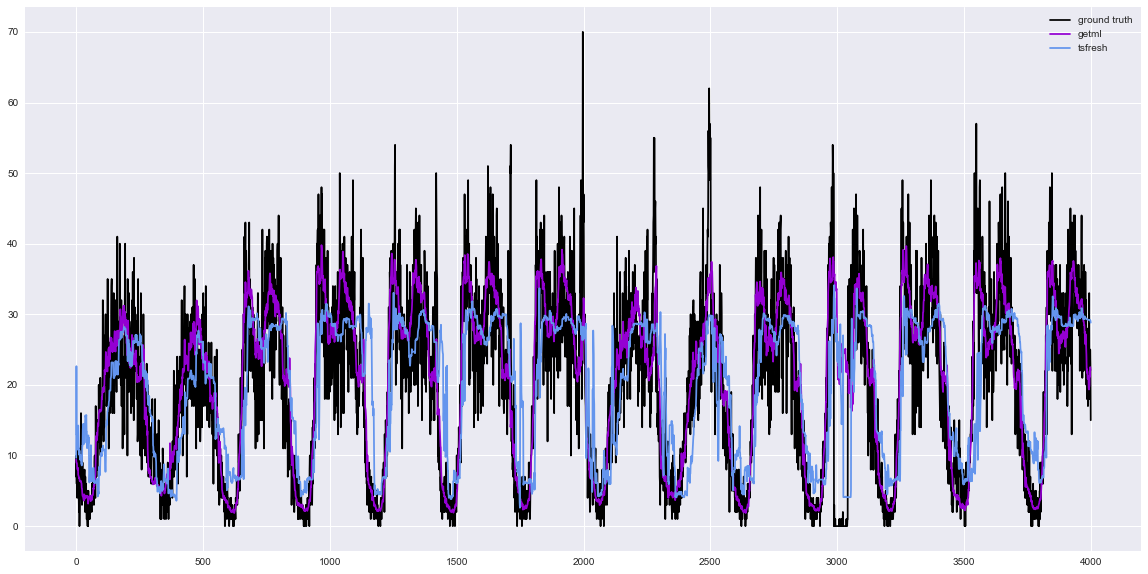

In [42]:
length = 4000

plt.subplots(figsize=(20, 10))

plt.plot(np.asarray(data_test_pandas["y"])[:length], color=col_data, label="ground truth")
plt.plot(predictions_getml_test[:length], color=col_getml, label="getml")
plt.plot(predictions_tsfresh_test[:length], color=col_prophet, label="tsfresh")
plt.legend(loc="upper right")

As we can see, tsfresh struggles with the strong seasonal components of this data set and therefore cannot separate signal from noise to the same extent that getML can.

### 2.6 Combining Prophet and tsfresh

Prophet is good at extracting seasonal features. tsfresh is good at extracting autoregressive features. So what if we tried to combine them? How well would that perform compared to getML?

Let's give it a try. We begin by extracting all of the seasonal features from Prophet and combining them with the tsfresh features:

In [43]:
def combine(dfs):
    combined = pd.DataFrame()
    for df in dfs:
        df = df.copy()
        if "id" in df.columns:
            del df["id"]
        df = df.reset_index()
        for col in df.columns:
            combined[col] = df[col]
    return combined

if RUN_PROPHET:
    prophet_train_pandas = model_prophet.predict(data_train_tsfresh)
    prophet_test_pandas = model_prophet.predict(data_test_tsfresh)

    combined_train_pandas = combine([tsfresh_train_pandas, prophet_train_pandas])
    combined_test_pandas = combine([tsfresh_test_pandas, prophet_test_pandas])
else:
    combined_train_pandas = pd.read_csv("combined_train_pandas.csv")
    combined_test_pandas = pd.read_csv("combined_test_pandas.csv")

We upload the data to getML:

In [44]:
combined_train = getml.data.DataFrame.from_pandas(combined_train_pandas, "combined_train")
combined_test = getml.data.DataFrame.from_pandas(combined_test_pandas, "combined_test")

The multiplicative terms are all zero, so we set them to unused to avoid an ugly warning message we would get from getML.

In [45]:
for df in [combined_train, combined_test]:
    df.set_role("y", getml.data.roles.target)
    df.set_role("ds", getml.data.roles.time_stamp)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)
    df.set_role(["multiplicative_terms", "multiplicative_terms_lower", "multiplicative_terms_upper", "y_lagged"], getml.data.roles.unused_float)

Once again, we train an untuned XGBoostRegressor on top of these features.

In [46]:
predictor = getml.predictors.XGBoostRegressor()

pipe_combined = getml.pipeline.Pipeline(
    tags=['prophet + tsfresh'],
    predictors=[predictor]
)

In [47]:
pipe_combined.fit(combined_train)

Checking data model...
OK.

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:3.135713



Pipeline(preprocessors=[],
         feature_learners=[],
         feature_selectors=[],
         include_categorical=False,
         peripheral=[],
         population='POPULATION',
         predictors=['XGBoostRegressor'],
         tags=['prophet + tsfresh'],
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/dodgers/hxYqz5/0/

In [48]:
pipe_combined.score(combined_test)

,date time,set used,target,mae,rmse,rsquared
0,2021-05-20 12:15:56,combined_train,y,4.6571,6.3999,0.7634
1,2021-05-20 12:15:56,combined_test,y,6.1773,8.4082,0.6661


As we can see, combining tsfresh and Prophet generates better predictions than any single one of them, but it is still considerably worse than getML.

In [49]:
predictions_combined_test = pipe_combined.predict(combined_test)

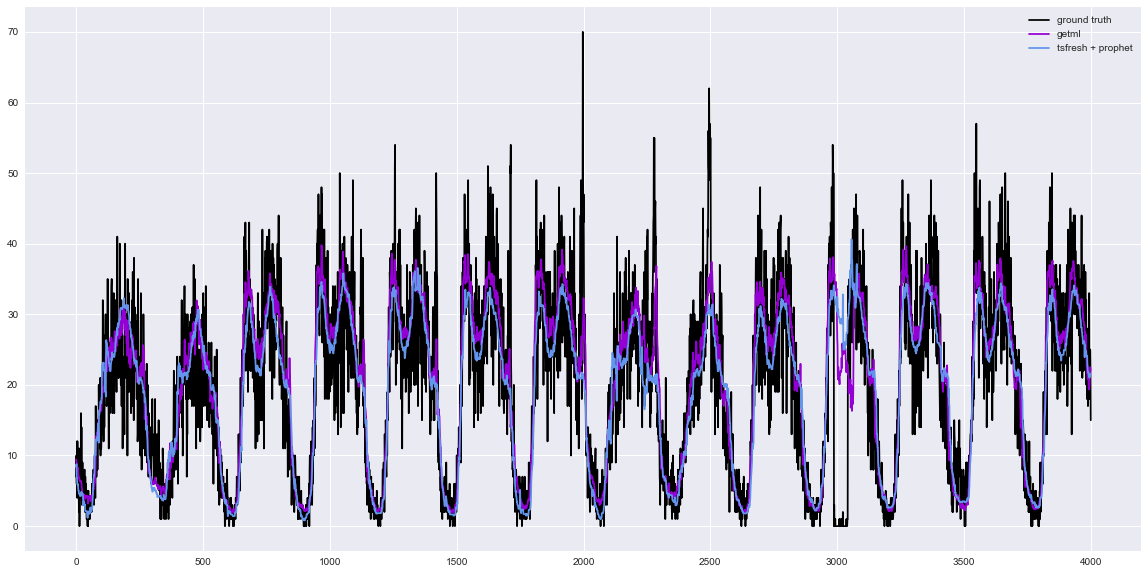

In [50]:
length = 4000

plt.subplots(figsize=(20, 10))

plt.plot(np.asarray(data_test_pandas["y"])[:length], color=col_data, label="ground truth")
plt.plot(predictions_getml_test[:length], color=col_getml, label="getml")
plt.plot(predictions_combined_test[:length], color=col_prophet, label="tsfresh + prophet")
plt.legend(loc="upper right")

### 2.7 Summary of results

For a more convenient overview, we summarize these results into a table.

Name                 | R-squared | RMSE | MAE
-------------------- | --------- | ---- | ----
getML                |       76% | 6.39 | 4.64
Prophet              |       63% | 8.32 | 6.22
tsfresh              |       49% | 9.30 | 7.19
Prophet + tsfresh    |       67% | 8.41 | 6.18


As we can see, getML outperforms both Prophet and tsfresh by all three measures.


## 3. Conclusion

We have compared getML's feature learning algorithms to Prophet and tsfresh on a data set related to traffic on LA's 101 North freeway. We found that getML significantly outperforms both Prophet and tsfresh. These results are consistent with the view that relational learning is a powerful tool for time series analysis.

You are encouraged to reproduce these results. You will need getML (https://getml.com/product) to do so. You can download it for free.

# Next Steps

This tutorial went showcased another time series application of getML and benchmarked getML against popular time series libraries.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.